In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from typing import List, Tuple
import requests

In [3]:
img_url_1 = "https://thumbs.dreamstime.com/b/empty-reading-room-4758931.jpg"
response = requests.get(img_url_1)
img_data_1 = response.content
img_array_1 = np.frombuffer(img_data_1, np.uint8)
image_1 = cv2.cvtColor(cv2.imdecode(img_array_1, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB).astype('double') / 255.0

img_url_2 = "https://static.wikia.nocookie.net/duckpond/images/b/b1/Cirnofumo.jpg/revision/latest/thumbnail/width/360/height/450?cb=20210727172305https://static.wikia.nocookie.net/duckpond/images/b/b1/Cirnofumo.jpg/revision/latest/thumbnail/width/360/height/450?cb=20210727172305"
response = requests.get(img_url_2)
img_data_2 = response.content
img_array_2 = np.frombuffer(img_data_2, np.uint8)
image_2 = cv2.cvtColor(cv2.imdecode(img_array_2, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB).astype('double') / 255.0

(507, 800, 3) (450, 343, 3)


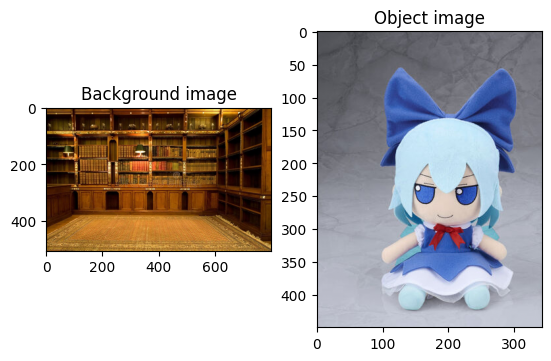

In [4]:
print(image_1.shape,image_2.shape)

plt.subplot(1, 2, 1)
plt.title("Background image")
plt.imshow(image_1)

plt.subplot(1, 2, 2)
plt.title("Object image")
plt.imshow(image_2)

plt.show()

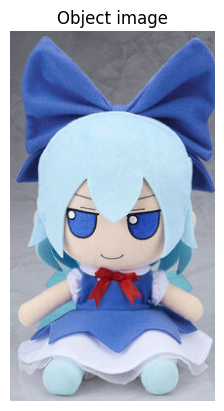

In [5]:
object_image_2 = image_2[50:430,90:300]
plt.title("Object image")
plt.imshow(object_image_2)
plt.axis('off')
plt.show()

In [6]:
def shrink_image(image, n):
    original_height, original_width = image.shape[:2]

    new_width = original_width // n
    new_height = original_height // n

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_image

In [7]:
def create_mark_image(original_img, insert_x, insert_y, object_image):
    insert_height, insert_width, _ = object_image.shape
    bg_height, bg_width, _ = original_img.shape
    mark_img = np.zeros((bg_height,bg_width))
    mark_img[insert_y:insert_y + insert_height, insert_x:insert_x + insert_width] = 1 
    
    return mark_img

(np.float64(-0.5), np.float64(799.5), np.float64(506.5), np.float64(-0.5))

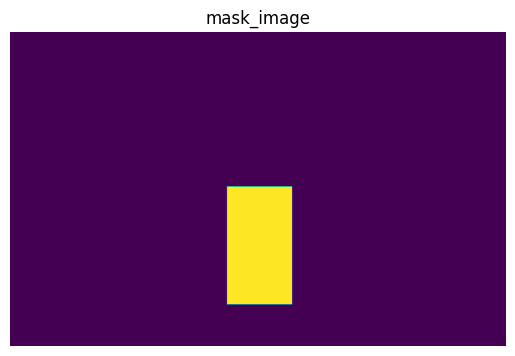

In [8]:
object_image = shrink_image(object_image_2,2)
mask_image = create_mark_image(image_1, 350, 250, object_image)
plt.title("mask_image")
plt.imshow(mask_image)
plt.axis('off')

In [9]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:

    pairs = []
    
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    
    return pairs

In [10]:
def poisson_blend(
    img_s: np.ndarray, 
    mask: np.ndarray, 
    img_t: np.ndarray
) -> np.ndarray:

    img_s_h, img_s_w = img_s.shape
    
    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)
    
    ys, xs = np.where(mask==1) 
        
    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]  
        
        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]
            
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    
    img_t_out = img_t.copy()
    
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    
    return np.clip(img_t_out, 0, 1)

In [19]:
blend_img = np.zeros(image_1.shape)
for b in np.arange(3):
    blend_img[:,:,b] = poisson_blend(object_image[:,:,b], mask_image, image_1[:,:,b].copy())


IndexError: index 507 is out of bounds for axis 0 with size 507

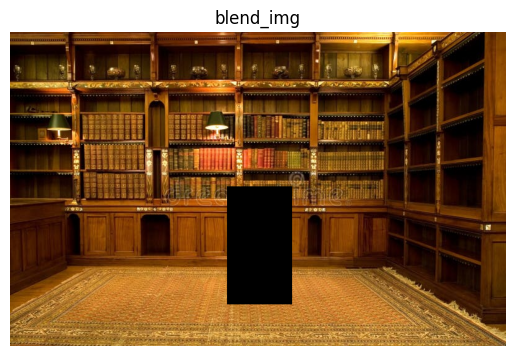

In [12]:
plt.title("blend_img")
plt.imshow(blend_img)
plt.axis('off')
plt.show()

In [13]:
hand_url = "https://www.ucl.ac.uk/news/sites/news/files/styles/large_image/public/hand_pic.jpg?itok=j_OFNGg7"
response = requests.get(hand_url)
hand_img = response.content
hand_img = np.frombuffer(hand_img, np.uint8)
hand_img = cv2.cvtColor(cv2.imdecode(hand_img, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB).astype('double') / 255.0

eye_url = "https://wechope.org/wp-content/uploads/2021/10/Closeup-of-boy-brown-eye-1030x606.jpg"
response = requests.get(eye_url)
eye_img = response.content
eye_img = np.frombuffer(eye_img, np.uint8)
eye_img = cv2.cvtColor(cv2.imdecode(eye_img, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB).astype('double') / 255.0

In [14]:
print(hand_img.shape, eye_img.shape)

(874, 768, 3) (606, 1030, 3)


(np.float64(-0.5), np.float64(767.5), np.float64(873.5), np.float64(-0.5))

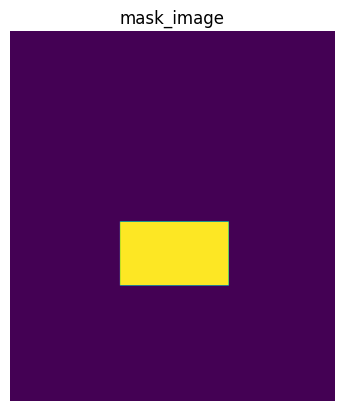

In [15]:
object_image = shrink_image(eye_img,4)
mask_image = create_mark_image(hand_img, 260, 450, object_image)
plt.title("mask_image")
plt.imshow(mask_image)
plt.axis('off')

In [22]:
blend_img = np.zeros(hand_img.shape)
for b in np.arange(3):
    blend_img[:,:,b] = poisson_blend(eye_img[:,:,b], mask_image, hand_img[:,:,b].copy())

(np.float64(-0.5), np.float64(767.5), np.float64(873.5), np.float64(-0.5))

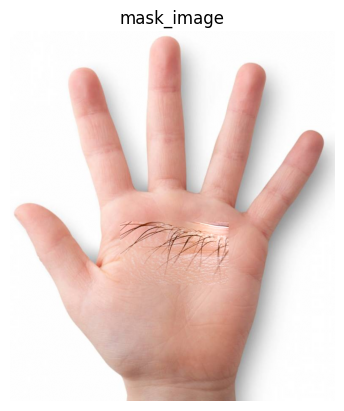

In [23]:
plt.title("mask_image")
plt.imshow(blend_img)
plt.axis('off')